<br>
<font>
<div dir=ltr align=center>
<img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width=150 height=150> <br>
<font color=0F5298 size=7>
    Machine learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2025<br>
<font color=3C99D size=5>
    Sentiment Analysis with Transformer <br>
</div>
<div dir=ltr align=center>
<font color=0CBCDF size=4>
    Mohammad Ebrahimian, Taha Izadi, Nima Ghadirniya
<font color=0CBCDF size=4>
</div>

____

  <h1 style="color:#0F5298; font-family:serif; font-size:45px; margin-bottom:0px;">
    Setup and Libraries
  </h1>

In [1]:
!pip install gensim
!pip install datasets==2.16.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 62.2 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.4/166.4 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 8.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
  Attempting uninstall: dill
    Found existing installation: dill 0.3.8
    Uninstalling dill-0.3.8:
      Successfully uninstalled dill-0.3.8
  Attempting uninstall: multiprocess
    Found existing installation: multiprocess 0.70.16
    Uninstalling multiprocess-0.70.16:
      Successful

In [2]:
import os
import gc
import math
import glob
import json
import random
import re
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
import torch.optim as optim
from itertools import product
import torch.nn.functional as F
import gensim.downloader as api
import matplotlib.pyplot as plt
from datetime import datetime
from datasets import load_dataset
from dataclasses import dataclass
from sklearn.metrics import f1_score
from transformers import BertTokenizer
from typing import Dict, List, Optional
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    if torch.backends.mps.is_available():
        torch.mps.manual_seed(seed)

set_seed(42)
print("🌱 Seed set to 42 for reproducibility.")

device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Device set to: {device}")

🌱 Seed set to 42 for reproducibility.
Device set to: cuda


  <h1 style="color:#0F5298; font-family:serif; font-size:45px; margin-bottom:0px;">
    Data Loading
  </h1>

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/2264 [00:00<?, ? examples/s]

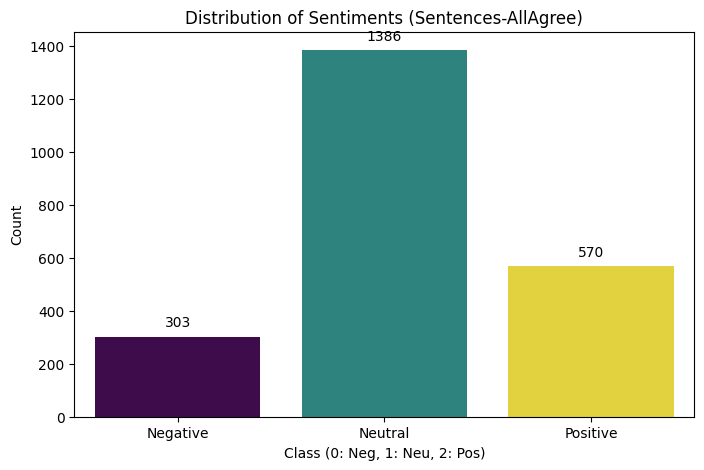

Total unique samples: 2259

📝 Samples per Class:
   - Negative (Label 0): "jan. 6 -- ford is struggling in the face of slowing truck and suv sales and a surfeit of up-to-date ..."
   - Neutral (Label 1): "according to gran , the company has no plans to move all production to russia , although that is whe..."
   - Positive (Label 2): "for the last quarter of 2010 , componenta 's net sales doubled to eur131m from eur76m for the same p..."


In [3]:
def load_data_from_file():
    ds = load_dataset(
        "financial_phrasebank",
        "sentences_allagree",
        trust_remote_code=True,
        streaming=False
    )
    df = ds["train"].to_pandas()
    df = df.rename(columns={"sentence": "text"})

    df = df.drop_duplicates(subset=['text'])
    df = df.dropna(subset=['text', 'label'])

    df['text'] = df['text'].str.lower().str.strip()

    df = df.dropna(subset=['label'])
    df['label'] = df['label'].astype(int)

    return df.reset_index(drop=True)

def plot_sentiment_distribution(df):
    plt.figure(figsize=(8, 5))
    ax = sns.countplot(x='label', data=df, palette='viridis', hue='label', legend=False)
    plt.title('Distribution of Sentiments (Sentences-AllAgree)')
    plt.xlabel('Class (0: Neg, 1: Neu, 2: Pos)')
    plt.ylabel('Count')
    plt.xticks([0, 1, 2], ['Negative', 'Neutral', 'Positive'])

    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    plt.show()

df = load_data_from_file()
plot_sentiment_distribution(df)
print(f"Total unique samples: {len(df)}")
print("\n📝 Samples per Class:")
label_names = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}

for label in [0, 1, 2]:
    sample_text = df[df['label'] == label]['text'].iloc[0]
    print(f"   - {label_names[label]} (Label {label}): \"{sample_text[:100]}...\"")

  <h1 style="color:#0F5298; font-family:serif; font-size:45px; margin-bottom:0px;">
    Word2Vec Pre-trained embeding
  </h1>

In [4]:
def create_hybrid_embeddings(tokenizer, d_emb=300):
    print("Loading Word2Vec model...")
    try:
        word2vec = api.load("word2vec-google-news-300")
    except Exception as e:
        print(f"Word2Vec load failed: {e}")
        vocab_size = len(tokenizer)
        mat = np.random.normal(0.0, 0.02, (vocab_size, d_emb)).astype(np.float32)
        if tokenizer.pad_token_id is not None:
            mat[tokenizer.pad_token_id] = 0.0
        return torch.from_numpy(mat)

    vocab = tokenizer.get_vocab()
    vocab_size = len(vocab)
    mat = np.random.normal(0.0, 0.02, (vocab_size, d_emb)).astype(np.float32)

    special_ids = set(tokenizer.all_special_ids)
    hits, misses, skipped_subword = 0, 0, 0

    for token, idx in vocab.items():
        if idx in special_ids:
            continue
        if token.startswith("##"):
            skipped_subword += 1
            continue

        if token in word2vec:
            mat[idx] = word2vec[token]
            hits += 1
        elif token.lower() in word2vec:
            mat[idx] = word2vec[token.lower()]
            hits += 1
        else:
            misses += 1

    if tokenizer.pad_token_id is not None:
        mat[tokenizer.pad_token_id] = 0.0

    del word2vec
    gc.collect()

    eligible = hits + misses
    cov = (hits / eligible * 100) if eligible > 0 else 0.0
    print(f"Shape: {mat.shape}")
    print(f"Hits: {hits}, Misses: {misses}, Skipped subwords: {skipped_subword}")
    print(f"Coverage on eligible tokens: {cov:.1f}%")

    return torch.from_numpy(mat)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
pretrained_embeddings = create_hybrid_embeddings(tokenizer)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Loading Word2Vec model...
[==================================================] 100.0% 1662.8/1662.8MB downloaded
Shape: (30522, 300)
Hits: 20174, Misses: 4515, Skipped subwords: 5828
Coverage on eligible tokens: 81.7%


  <h1 style="color:#0F5298; font-family:serif; font-size:45px; margin-bottom:0px;">
    Data Spliting
  </h1>

In [5]:
SEED = 42
TRAIN_SIZE = 0.80
VAL_SIZE = 0.10
TEST_SIZE = 0.10

assert abs(TRAIN_SIZE + VAL_SIZE + TEST_SIZE - 1.0) < 1e-8, "Split ratios must sum to 1."

if df["label"].dtype == object:
    label_map = {"negative": 0, "neutral": 1, "positive": 2}
    df["label"] = df["label"].map(label_map)

df = df.dropna(subset=["text", "label"]).copy()
df["label"] = df["label"].astype(int)
df = df.reset_index(drop=True)

train_df, temp_df = train_test_split(
    df,
    test_size=(1 - TRAIN_SIZE),
    random_state=SEED,
    stratify=df["label"],
)

val_ratio_in_temp = VAL_SIZE / (VAL_SIZE + TEST_SIZE)
val_df, test_df = train_test_split(
    temp_df,
    test_size=(1 - val_ratio_in_temp),
    random_state=SEED,
    stratify=temp_df["label"],
)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

def show_split_stats(name, part_df):
    counts = part_df["label"].value_counts().sort_index()
    ratios = (part_df["label"].value_counts(normalize=True).sort_index() * 100).round(2)
    print(f"{name}: n={len(part_df)}")
    print("counts:", counts.to_dict())
    print("ratios(%):", ratios.to_dict())
    print("-" * 50)

show_split_stats("Train", train_df)
show_split_stats("Validation", val_df)
show_split_stats("Test", test_df)

Train: n=1807
counts: {0: 242, 1: 1109, 2: 456}
ratios(%): {0: 13.39, 1: 61.37, 2: 25.24}
--------------------------------------------------
Validation: n=226
counts: {0: 30, 1: 139, 2: 57}
ratios(%): {0: 13.27, 1: 61.5, 2: 25.22}
--------------------------------------------------
Test: n=226
counts: {0: 31, 1: 138, 2: 57}
ratios(%): {0: 13.72, 1: 61.06, 2: 25.22}
--------------------------------------------------


  <h1 style="color:#0F5298; font-family:serif; font-size:45px; margin-bottom:0px;">
    Augmentation
  </h1>

In [6]:
COMMON_SYNONYMS = {
    "company": ["firm", "business"],
    "market": ["sector", "marketplace"],
    "shares": ["stock", "equity"],
    "announced": ["reported", "stated"],
    "increase": ["rise", "growth"],
    "decrease": ["decline", "drop"],
    "cost": ["expense", "charge"],
    "revenue": ["sales", "turnover"],
}

LABEL_SYNONYMS = {
    0: {"loss": ["deficit", "setback"], "risk": ["threat", "uncertainty"], "fall": ["drop", "decline"]},
    1: {"said": ["stated", "noted"], "expects": ["anticipates", "foresees"], "plan": ["strategy", "program"]},
    2: {"profit": ["gain", "earnings"], "growth": ["expansion", "rise"], "strong": ["solid", "robust"]},
}

PROTECTED_WORDS = {"not", "no", "never", "none", "without"}


def _normalize_token(token: str) -> str:
    return re.sub(r"^[^A-Za-z0-9]+|[^A-Za-z0-9]+$", "", token).lower()


def _replace_token_keep_format(raw_token: str, new_core: str) -> str:
    m = re.match(r"^([^A-Za-z0-9]*)([A-Za-z0-9'-]+)([^A-Za-z0-9]*)$", raw_token)
    if not m:
        return raw_token
    prefix, core, suffix = m.groups()
    if core.isupper():
        new_core = new_core.upper()
    elif core[:1].isupper():
        new_core = new_core.capitalize()
    return f"{prefix}{new_core}{suffix}"


def augment_text_label_aware(text: str, label: int, rng: random.Random, max_repl: int = 2, swap_prob: float = 0.10):
    words = text.split()
    if len(words) < 3:
        return text

    syn_map = {**COMMON_SYNONYMS, **LABEL_SYNONYMS.get(int(label), {})}
    candidates = []

    for i, w in enumerate(words):
        key = _normalize_token(w)
        if not key or key in PROTECTED_WORDS or any(ch.isdigit() for ch in key):
            continue
        if key in syn_map:
            candidates.append((i, key))

    rng.shuffle(candidates)

    if candidates:
        n_rep = rng.randint(1, min(max_repl, len(candidates)))
        for i, key in candidates[:n_rep]:
            replacement = rng.choice(syn_map[key])
            words[i] = _replace_token_keep_format(words[i], replacement)

    if rng.random() < swap_prob and len(words) >= 5:
        j = rng.randrange(0, len(words) - 1)
        words[j], words[j + 1] = words[j + 1], words[j]

    aug = " ".join(words).strip()
    return aug if aug else text


def _compute_target_counts(class_counts: pd.Series, balance_strength: float = 0.45, max_growth: float = 1.40):
    class_counts = class_counts.sort_index()
    max_count = int(class_counts.max())
    orig_total = int(class_counts.sum())

    targets = {}
    for label, count in class_counts.items():
        boosted = int(round(count + balance_strength * (max_count - count)))
        targets[int(label)] = max(int(count), boosted)

    max_total = int(round(orig_total * max_growth))
    proposed_total = sum(targets.values())

    if proposed_total > max_total and proposed_total > orig_total:
        proposed_extra = proposed_total - orig_total
        allowed_extra = max_total - orig_total
        scale = allowed_extra / proposed_extra if proposed_extra > 0 else 0.0
        for label, count in class_counts.items():
            extra = targets[int(label)] - int(count)
            scaled_extra = int(round(extra * scale))
            targets[int(label)] = int(count) + max(0, scaled_extra)

    return targets

# Augmenting training data
def build_controlled_augmented_train_df(
    train_df: pd.DataFrame,
    seed: int = 42,
    balance_strength: float = 1.0,
    max_growth: float = 10.0,
):
    rng = random.Random(seed)

    base = train_df[["text", "label"]].copy().reset_index(drop=True)
    base["is_augmented"] = 0

    class_counts = base["label"].value_counts().sort_index()
    target_counts = _compute_target_counts(class_counts, balance_strength=balance_strength, max_growth=max_growth)

    parts = []
    for label, grp in base.groupby("label", sort=True):
        grp = grp.copy().reset_index(drop=True)
        originals = grp["text"].tolist()
        seen = set(t.strip().lower() for t in originals)

        need = max(0, target_counts[int(label)] - len(grp))
        new_rows = []
        attempts = 0
        max_attempts = max(200, need * 20)

        while len(new_rows) < need and attempts < max_attempts:
            src = originals[rng.randrange(len(originals))]
            aug = augment_text_label_aware(src, int(label), rng, max_repl=2, swap_prob=0.10)
            attempts += 1

            key = aug.strip().lower()
            if not key or key in seen:
                continue

            seen.add(key)
            new_rows.append({"text": aug, "label": int(label), "is_augmented": 1})

        if len(new_rows) < need:
            remain = need - len(new_rows)
            sampled = grp.sample(n=remain, replace=True, random_state=seed)["text"].tolist()
            for src in sampled:
                aug = augment_text_label_aware(src, int(label), rng, max_repl=1, swap_prob=0.05)
                new_rows.append({"text": aug, "label": int(label), "is_augmented": 1})

        parts.append(grp)
        if new_rows:
            parts.append(pd.DataFrame(new_rows))

    train_aug_df = pd.concat(parts, ignore_index=True)
    train_aug_df = train_aug_df.sample(frac=1.0, random_state=seed).reset_index(drop=True)
    return train_aug_df


def show_counts(train_part, val_part, test_part, title):
    print(f"\n{title}")
    print("=" * len(title))
    for name, part in [("Train", train_part), ("Validation", val_part), ("Test", test_part)]:
        c = part["label"].value_counts().sort_index().to_dict()
        print(f"{name}: n={len(part)} | class_counts={c}")


assert "train_df" in globals() and "val_df" in globals() and "test_df" in globals(), "run data spliting block first"

seed_value = SEED if "SEED" in globals() else 42

show_counts(train_df, val_df, test_df, "Before Augmentation")

train_aug_df = build_controlled_augmented_train_df(
    train_df=train_df,
    seed=seed_value,
    balance_strength=1,
    max_growth=3,
)

show_counts(train_aug_df, val_df, test_df, "After Augmentation")
print(f"Added train samples: {len(train_aug_df) - len(train_df)}")
print("Augmented flag:", train_aug_df["is_augmented"].value_counts().to_dict())




Before Augmentation
Train: n=1807 | class_counts={0: 242, 1: 1109, 2: 456}
Validation: n=226 | class_counts={0: 30, 1: 139, 2: 57}
Test: n=226 | class_counts={0: 31, 1: 138, 2: 57}

After Augmentation
Train: n=3327 | class_counts={0: 1109, 1: 1109, 2: 1109}
Validation: n=226 | class_counts={0: 30, 1: 139, 2: 57}
Test: n=226 | class_counts={0: 31, 1: 138, 2: 57}
Added train samples: 1520
Augmented flag: {0: 1807, 1: 1520}


  <h1 style="color:#0F5298; font-family:serif; font-size:45px; margin-bottom:0px;">
    Data loader
  </h1>

In [7]:
class FinancialDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=64):
        self.texts = list(texts)
        self.labels = list(labels)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])

        enc = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt",
        )
        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long),
        }

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
MAX_LEN = 64
BATCH_SIZE = 32

train_dataset = FinancialDataset(train_aug_df["text"].values, train_aug_df["label"].values, tokenizer, MAX_LEN)
val_dataset   = FinancialDataset(val_df["text"].values, val_df["label"].values, tokenizer, MAX_LEN)
test_dataset  = FinancialDataset(test_df["text"].values, test_df["label"].values, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train samples: {len(train_dataset)} | batches: {len(train_loader)}")
print(f"Val samples:   {len(val_dataset)} | batches: {len(val_loader)}")
print(f"Test samples:  {len(test_dataset)} | batches: {len(test_loader)}")

Train samples: 3327 | batches: 104
Val samples:   226 | batches: 8
Test samples:  226 | batches: 8


  <h1 style="color:#0F5298; font-family:serif; font-size:45px; margin-bottom:0px;">
    The Architecture (Transformer)
  </h1>

In [8]:
@dataclass(frozen=True)
class ModelConfig:
    vocab_size: int
    num_classes: int
    max_len: int
    d_model: int
    num_heads: int
    num_layers: int
    d_ff: int
    dropout: float
    attn_dropout: float
    pad_token_id: int = 0


class MultiHeadSelfAttention(nn.Module):
    def __init__(self, d_model: int, num_heads: int, attn_dropout: float, proj_dropout: float):
        super().__init__()
        if d_model % num_heads != 0:
            raise ValueError("d_model must be divisible by num_heads")
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.scale = self.head_dim ** -0.5

        self.qkv = nn.Linear(d_model, 3 * d_model, bias=True)
        self.attn_drop = nn.Dropout(attn_dropout)
        self.proj = nn.Linear(d_model, d_model, bias=True)
        self.proj_drop = nn.Dropout(proj_dropout)

    def forward(self, x: torch.Tensor, attention_mask: Optional[torch.Tensor] = None):
        bsz, seq_len, _ = x.shape
        qkv = self.qkv(x).view(bsz, seq_len, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        scores = torch.matmul(q, k.transpose(-2, -1)) * self.scale

        if attention_mask is not None:
            key_mask = attention_mask[:, None, None, :].to(torch.bool)
            scores = scores.masked_fill(~key_mask, torch.finfo(scores.dtype).min)

        attn = F.softmax(scores, dim=-1)
        attn = self.attn_drop(attn)

        context = torch.matmul(attn, v).transpose(1, 2).contiguous().view(bsz, seq_len, self.d_model)
        out = self.proj_drop(self.proj(context))
        return out, attn


class FeedForward(nn.Module):
    def __init__(self, d_model: int, d_ff: int, dropout: float):
        super().__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.drop1 = nn.Dropout(dropout)
        self.drop2 = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor):
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.drop1(x)
        x = self.fc2(x)
        x = self.drop2(x)
        return x


class TransformerEncoderBlock(nn.Module):
    def __init__(self, d_model: int, num_heads: int, d_ff: int, dropout: float, attn_dropout: float):
        super().__init__()
        self.norm1 = nn.LayerNorm(d_model)
        self.attn = MultiHeadSelfAttention(d_model, num_heads, attn_dropout=attn_dropout, proj_dropout=dropout)
        self.norm2 = nn.LayerNorm(d_model)
        self.ffn = FeedForward(d_model, d_ff, dropout=dropout)

    def forward(self, x: torch.Tensor, attention_mask: Optional[torch.Tensor] = None):
        h, attn = self.attn(self.norm1(x), attention_mask)
        x = x + h
        x = x + self.ffn(self.norm2(x))
        return x, attn


class FinancialTransformer(nn.Module):
    def __init__(self, config: ModelConfig, pretrained_embeddings: Optional[torch.Tensor] = None):
        super().__init__()
        emb_dim = pretrained_embeddings.size(1) if pretrained_embeddings is not None else config.d_model

        self.token_embedding = nn.Embedding(config.vocab_size, emb_dim, padding_idx=config.pad_token_id)
        self.input_proj = nn.Identity() if emb_dim == config.d_model else nn.Linear(emb_dim, config.d_model, bias=False)
        self.position_embedding = nn.Embedding(config.max_len, config.d_model)
        self.embed_norm = nn.LayerNorm(config.d_model)
        self.embed_drop = nn.Dropout(config.dropout)

        self.layers = nn.ModuleList(
            [
                TransformerEncoderBlock(
                    d_model=config.d_model,
                    num_heads=config.num_heads,
                    d_ff=config.d_ff,
                    dropout=config.dropout,
                    attn_dropout=config.attn_dropout,
                )
                for _ in range(config.num_layers)
            ]
        )

        self.final_norm = nn.LayerNorm(config.d_model)
        self.cls_drop = nn.Dropout(config.dropout)
        self.classifier = nn.Linear(config.d_model, config.num_classes)

        has_pretrained = pretrained_embeddings is not None
        self._init_weights(skip_token_embedding=has_pretrained)

        if has_pretrained:
            if pretrained_embeddings.size(0) != config.vocab_size:
                raise ValueError("pretrained_embeddings vocab_size mismatch")
            with torch.no_grad():
                self.token_embedding.weight.copy_(pretrained_embeddings)
                if self.token_embedding.padding_idx is not None:
                    self.token_embedding.weight[self.token_embedding.padding_idx].zero_()

    def _init_weights(self, skip_token_embedding: bool = False):
        for name, m in self.named_modules():
            if skip_token_embedding and name == "token_embedding":
                continue
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Embedding):
                nn.init.normal_(m.weight, mean=0.0, std=0.02)
                if m.padding_idx is not None:
                    with torch.no_grad():
                        m.weight[m.padding_idx].zero_()

    def forward(self, input_ids: torch.Tensor, attention_mask: Optional[torch.Tensor] = None, return_attention: bool = False):
        if attention_mask is None:
            attention_mask = torch.ones_like(input_ids)

        bsz, seq_len = input_ids.shape
        if seq_len > self.position_embedding.num_embeddings:
            raise ValueError("seq_len exceeds max_len in config")

        pos_ids = torch.arange(seq_len, device=input_ids.device).unsqueeze(0).expand(bsz, seq_len)

        x = self.token_embedding(input_ids)
        x = self.input_proj(x)
        x = x + self.position_embedding(pos_ids)
        x = self.embed_norm(x)
        x = self.embed_drop(x)

        attn_maps = []
        for layer in self.layers:
            x, attn = layer(x, attention_mask)
            if return_attention:
                attn_maps.append(attn)

        x = self.final_norm(x)
        mask = attention_mask.unsqueeze(-1).type_as(x)
        pooled = (x * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1.0)
        logits = self.classifier(self.cls_drop(pooled))

        if return_attention:
            return logits, attn_maps
        return logits


DEFAULT_SEARCH_SPACE = {
    "d_model": [128, 192, 256],
    "num_heads": [4, 8],
    "num_layers": [3, 4],
    "ff_mult": [3],
    "dropout": [0.1, 0.2, 0.3],
    "attn_dropout": [0.1],
}


def generate_valid_model_configs(
    vocab_size: int,
    num_classes: int,
    max_len: int,
    pad_token_id: int = 0,
    search_space: Optional[Dict[str, List]] = None,
) -> List[ModelConfig]:
    space = search_space or DEFAULT_SEARCH_SPACE
    configs: List[ModelConfig] = []

    for d_model, num_heads, num_layers, ff_mult, dropout, attn_dropout in product(
        space["d_model"],
        space["num_heads"],
        space["num_layers"],
        space["ff_mult"],
        space["dropout"],
        space["attn_dropout"],
    ):
        if d_model % num_heads != 0:
            continue

        cfg = ModelConfig(
            vocab_size=vocab_size,
            num_classes=num_classes,
            max_len=max_len,
            d_model=int(d_model),
            num_heads=int(num_heads),
            num_layers=int(num_layers),
            d_ff=int(d_model * ff_mult),
            dropout=float(dropout),
            attn_dropout=float(attn_dropout),
            pad_token_id=int(pad_token_id),
        )
        configs.append(cfg)

    return configs


def build_model_from_config(
    config: ModelConfig,
    pretrained_embeddings: Optional[torch.Tensor] = None,
    device: Optional[torch.device] = None,
) -> FinancialTransformer:
    model = FinancialTransformer(config=config, pretrained_embeddings=pretrained_embeddings)
    if device is not None:
        model = model.to(device)
    return model



  <h1 style="color:#0F5298; font-family:serif; font-size:45px; margin-bottom:0px;">
    Generate Model
  </h1>

In [9]:
configs = generate_valid_model_configs(
    vocab_size=len(tokenizer),
    num_classes=3,
    max_len=MAX_LEN,
    pad_token_id=tokenizer.pad_token_id if tokenizer.pad_token_id is not None else 0
)

print(f"Total valid configs: {len(configs)}")
print("First config:", configs[0])

model = build_model_from_config(
    config=configs[0],
    pretrained_embeddings=pretrained_embeddings if "pretrained_embeddings" in globals() else None,
    device=device
)

print(f"Model params: {sum(p.numel() for p in model.parameters()):,}")


Total valid configs: 36
First config: ModelConfig(vocab_size=30522, num_classes=3, max_len=64, d_model=128, num_heads=4, num_layers=3, d_ff=384, dropout=0.1, attn_dropout=0.1, pad_token_id=0)
Model params: 9,700,219


  <h1 style="color:#0F5298; font-family:serif; font-size:45px; margin-bottom:0px;">
    Training Configuration & Class Weights
  </h1>

In [10]:
NUM_EPOCHS = 15
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 5e-4
LABEL_SMOOTHING = 0.03
BETAS = (0.9, 0.999)
EPS = 1e-8
WARMUP_RATIO = 0.1
MAX_GRAD_NORM = 1.0
EARLY_STOPPING_PATIENCE = 4
MIN_IMPROVEMENT = 5e-4
FREEZE_EMBED_EPOCHS = 2
SELECTION_METRIC = "macro_f1"
MAX_CONFIGS = 50

if "train_aug_df" in globals():
    y_train = train_aug_df["label"].astype(int).to_numpy()
elif "train_df" in globals():
    y_train = train_df["label"].astype(int).to_numpy()
elif "train_loader" in globals():
    labels_buffer = []
    for b in train_loader:
        labels_buffer.extend(b["labels"].cpu().numpy().tolist())
    y_train = np.array(labels_buffer, dtype=np.int64)
else:
    raise ValueError("No training labels found. Define train_df/train_aug_df or train_loader first.")

num_classes = 3
weights_np = compute_class_weight(class_weight="balanced", classes=np.arange(num_classes), y=y_train)
class_weights = torch.tensor(weights_np, dtype=torch.float32, device=device)

training_config = {
    "epochs": NUM_EPOCHS,
    "lr": LEARNING_RATE,
    "weight_decay": WEIGHT_DECAY,
    "label_smoothing": LABEL_SMOOTHING,
    "betas": BETAS,
    "eps": EPS,
    "warmup_ratio": WARMUP_RATIO,
    "max_grad_norm": MAX_GRAD_NORM,
    "early_stopping_patience": EARLY_STOPPING_PATIENCE,
    "min_improvement": MIN_IMPROVEMENT,
    "freeze_embed_epochs": FREEZE_EMBED_EPOCHS,
    "selection_metric": SELECTION_METRIC,
    "max_configs": MAX_CONFIGS,
}

print("Training config ready.")
print(training_config)
print("Class weights:", class_weights.detach().cpu().numpy())

Training config ready.
{'epochs': 15, 'lr': 0.0001, 'weight_decay': 0.0005, 'label_smoothing': 0.03, 'betas': (0.9, 0.999), 'eps': 1e-08, 'warmup_ratio': 0.1, 'max_grad_norm': 1.0, 'early_stopping_patience': 4, 'min_improvement': 0.0005, 'freeze_embed_epochs': 2, 'selection_metric': 'macro_f1', 'max_configs': 50}
Class weights: [1. 1. 1.]


  <h1 style="color:#0F5298; font-family:serif; font-size:45px; margin-bottom:0px;">
    Helpers
  </h1>

In [11]:
def _seed_all(seed: int = 42):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


def _get_train_labels():
    if "train_aug_df" in globals():
        return train_aug_df["label"].astype(int).to_numpy()
    if "train_df" in globals():
        return train_df["label"].astype(int).to_numpy()
    if "train_loader" in globals():
        labels = []
        for b in train_loader:
            labels.extend(b["labels"].cpu().numpy().tolist())
        return np.array(labels, dtype=np.int64)
    raise ValueError("No training labels found.")


def _build_scheduler(optimizer, num_epochs, steps_per_epoch, warmup_ratio):
    total_steps = max(1, num_epochs * steps_per_epoch)
    warmup_steps = int(warmup_ratio * total_steps)

    def lr_lambda(current_step):
        if current_step < warmup_steps:
            return float(current_step) / float(max(1, warmup_steps))
        progress = float(current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * progress)))

    return optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda), total_steps, warmup_steps


def _set_token_embedding_trainable(model, trainable: bool):
    if hasattr(model, "token_embedding"):
        for p in model.token_embedding.parameters():
            p.requires_grad = trainable


def _train_one_epoch(model, loader, criterion, optimizer, scheduler, max_grad_norm, device):
    model.train()
    total_loss, total_correct, total_samples = 0.0, 0, 0

    for batch in loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad(set_to_none=True)
        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(logits, labels)
        loss.backward()

        if max_grad_norm is not None and max_grad_norm > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

        optimizer.step()
        if scheduler is not None:
            scheduler.step()

        bs = labels.size(0)
        total_loss += loss.item() * bs
        total_correct += (logits.argmax(dim=1) == labels).sum().item()
        total_samples += bs

    return total_loss / max(1, total_samples), total_correct / max(1, total_samples)

test_labels = []
test_preds = []
@torch.no_grad()
def _eval_one_epoch(model, loader, criterion, device):
    model.eval()
    total_loss, total_correct, total_samples = 0.0, 0, 0
    all_labels, all_preds = [], []

    for batch in loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(logits, labels)
        preds = logits.argmax(dim=1)

        bs = labels.size(0)
        total_loss += loss.item() * bs
        total_correct += (preds == labels).sum().item()
        total_samples += bs

        all_labels.extend(labels.detach().cpu().numpy().tolist())
        all_preds.extend(preds.detach().cpu().numpy().tolist())

        test_labels.extend(labels.detach().cpu().numpy().tolist())
        test_preds.extend(preds.detach().cpu().numpy().tolist())

    macro_f1 = f1_score(all_labels, all_preds, average="macro", zero_division=0)
    return total_loss / max(1, total_samples), total_correct / max(1, total_samples), macro_f1


def _is_improved(metric_name, current_loss, current_f1, best_loss, best_f1, min_improvement):
    if metric_name == "val_loss":
        return current_loss < (best_loss - min_improvement)
    if current_f1 > (best_f1 + min_improvement):
        return True
    if abs(current_f1 - best_f1) <= 1e-12 and current_loss < best_loss:
        return True
    return False

  <h1 style="color:#0F5298; font-family:serif; font-size:45px; margin-bottom:0px;">
    Setup Runtime
  </h1>

In [12]:
if "train_loader" not in globals() or "val_loader" not in globals():
    raise ValueError("train_loader and val_loader must be defined before this block.")

if "configs" not in globals() or len(configs) == 0:
    if "MAX_LEN" not in globals():
        raise ValueError("MAX_LEN is required to generate configs.")
    configs = generate_valid_model_configs(
        vocab_size=len(tokenizer),
        num_classes=3,
        max_len=MAX_LEN,
        pad_token_id=tokenizer.pad_token_id if tokenizer.pad_token_id is not None else 0,
    )

seed_base = SEED if "SEED" in globals() else 42
num_epochs = training_config["epochs"] if "training_config" in globals() else 15
learning_rate = training_config["lr"] if "training_config" in globals() else 1e-4
weight_decay = training_config["weight_decay"] if "training_config" in globals() else 5e-4
label_smoothing = training_config["label_smoothing"] if "training_config" in globals() else 0.03
warmup_ratio = training_config["warmup_ratio"] if "training_config" in globals() else 0.1
max_grad_norm = training_config["max_grad_norm"] if "training_config" in globals() else 1.0
patience = training_config["early_stopping_patience"] if "training_config" in globals() else 4
min_improvement = training_config["min_improvement"] if "training_config" in globals() else 5e-4
freeze_embed_epochs = training_config["freeze_embed_epochs"] if "training_config" in globals() else 0
selection_metric = training_config["selection_metric"] if "training_config" in globals() else "wighted_f1"
max_configs = training_config["max_configs"] if "training_config" in globals() else 4
betas = training_config["betas"] if "training_config" in globals() else (0.9, 0.999)
eps = training_config["eps"] if "training_config" in globals() else 1e-8

if "class_weights" in globals() and class_weights is not None:
    cw = class_weights
else:
    y_train = _get_train_labels()
    w_np = compute_class_weight(class_weight="balanced", classes=np.arange(3), y=y_train).astype(np.float32)
    cw = torch.tensor(w_np, dtype=torch.float32, device=device)

pretrained_for_search = pretrained_embeddings if "pretrained_embeddings" in globals() else None
configs_to_run = configs[:max_configs]

print(f"Total configs available: {len(configs)}")
print(f"Configs selected to run: {len(configs_to_run)}")
print(f"Epochs per config: {num_epochs}")
print(f"Selection metric: {selection_metric}")

search_results = []
global_best = {
    "val_loss": float("inf"),
    "val_acc": 0.0,
    "val_macro_f1": -1.0,
    "config": None,
    "state_dict": None,
    "epoch": -1,
    "history": None,
}

for ci, cfg in enumerate(configs_to_run, start=1):
    _seed_all(seed_base)

    model_candidate = build_model_from_config(
        config=cfg,
        pretrained_embeddings=pretrained_for_search,
        device=device,
    )

    criterion = nn.CrossEntropyLoss(weight=cw, label_smoothing=label_smoothing)
    optimizer = optim.AdamW(
        model_candidate.parameters(),
        lr=learning_rate,
        weight_decay=weight_decay,
        betas=betas,
        eps=eps,
    )
    scheduler, total_steps, warmup_steps = _build_scheduler(
        optimizer=optimizer,
        num_epochs=num_epochs,
        steps_per_epoch=len(train_loader),
        warmup_ratio=warmup_ratio,
    )

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": [], "val_macro_f1": []}
    best_local_val_loss = float("inf")
    best_local_val_acc = 0.0
    best_local_val_macro_f1 = -1.0
    best_local_epoch = -1
    best_local_state = None
    no_improve = 0

    if pretrained_for_search is not None and freeze_embed_epochs > 0:
        _set_token_embedding_trainable(model_candidate, False)

    print(f"\n[{ci}/{len(configs_to_run)}] Config: {cfg}")

    for epoch in range(1, num_epochs + 1):
        if pretrained_for_search is not None and freeze_embed_epochs > 0 and epoch == (freeze_embed_epochs + 1):
            _set_token_embedding_trainable(model_candidate, True)

        train_loss, train_acc = _train_one_epoch(
            model=model_candidate,
            loader=train_loader,
            criterion=criterion,
            optimizer=optimizer,
            scheduler=scheduler,
            max_grad_norm=max_grad_norm,
            device=device,
        )

        val_loss, val_acc, val_macro_f1 = _eval_one_epoch(
            model=model_candidate,
            loader=val_loader,
            criterion=criterion,
            device=device,
        )

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["val_macro_f1"].append(val_macro_f1)

        print(
            f"Config {ci:03d} | Epoch {epoch:02d}/{num_epochs} | "
            f"train_loss={train_loss:.4f} train_acc={train_acc:.4f} | "
            f"val_loss={val_loss:.4f} val_acc={val_acc:.4f} val_macro_f1={val_macro_f1:.4f}"
        )

        improved = _is_improved(
            metric_name=selection_metric,
            current_loss=val_loss,
            current_f1=val_macro_f1,
            best_loss=best_local_val_loss,
            best_f1=best_local_val_macro_f1,
            min_improvement=min_improvement,
        )

        if improved:
            best_local_val_loss = val_loss
            best_local_val_acc = val_acc
            best_local_val_macro_f1 = val_macro_f1
            best_local_epoch = epoch
            best_local_state = {k: v.detach().cpu().clone() for k, v in model_candidate.state_dict().items()}
            no_improve = 0
        else:
            no_improve += 1

        if no_improve >= patience:
            print(f"Early stopping for config {ci} at epoch {epoch}.")
            break

    search_results.append(
        {
            "config_id": ci,
            "d_model": cfg.d_model,
            "num_heads": cfg.num_heads,
            "num_layers": cfg.num_layers,
            "d_ff": cfg.d_ff,
            "dropout": cfg.dropout,
            "attn_dropout": cfg.attn_dropout,
            "best_epoch": best_local_epoch,
            "best_val_loss": best_local_val_loss,
            "best_val_acc": best_local_val_acc,
            "best_val_macro_f1": best_local_val_macro_f1,
            "steps_total": total_steps,
            "warmup_steps": warmup_steps,
        }
    )

    if selection_metric == "val_loss":
        is_global_better = best_local_val_loss < global_best["val_loss"]
    else:
        is_global_better = (
            (best_local_val_macro_f1 > global_best["val_macro_f1"]) or
            (
                abs(best_local_val_macro_f1 - global_best["val_macro_f1"]) <= 1e-12 and
                best_local_val_loss < global_best["val_loss"]
            )
        )

    if is_global_better:
        global_best["val_loss"] = best_local_val_loss
        global_best["val_acc"] = best_local_val_acc
        global_best["val_macro_f1"] = best_local_val_macro_f1
        global_best["config"] = cfg
        global_best["state_dict"] = best_local_state
        global_best["epoch"] = best_local_epoch
        global_best["history"] = history

    del model_candidate, optimizer, scheduler, criterion
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

Total configs available: 36
Configs selected to run: 36
Epochs per config: 15
Selection metric: macro_f1

[1/36] Config: ModelConfig(vocab_size=30522, num_classes=3, max_len=64, d_model=128, num_heads=4, num_layers=3, d_ff=384, dropout=0.1, attn_dropout=0.1, pad_token_id=0)
Config 001 | Epoch 01/15 | train_loss=0.9940 train_acc=0.4881 | val_loss=0.7195 val_acc=0.6991 val_macro_f1=0.5284
Config 001 | Epoch 02/15 | train_loss=0.6929 train_acc=0.7069 | val_loss=0.5983 val_acc=0.7522 val_macro_f1=0.6495
Config 001 | Epoch 03/15 | train_loss=0.4736 train_acc=0.8407 | val_loss=0.4904 val_acc=0.8496 val_macro_f1=0.7832
Config 001 | Epoch 04/15 | train_loss=0.2685 train_acc=0.9405 | val_loss=0.5091 val_acc=0.8717 val_macro_f1=0.8183
Config 001 | Epoch 05/15 | train_loss=0.1972 train_acc=0.9742 | val_loss=0.4382 val_acc=0.8850 val_macro_f1=0.8611
Config 001 | Epoch 06/15 | train_loss=0.1694 train_acc=0.9880 | val_loss=0.4036 val_acc=0.8850 val_macro_f1=0.8536
Config 001 | Epoch 07/15 | train_lo

  <h1 style="color:#0F5298; font-family:serif; font-size:45px; margin-bottom:0px;">
    Rank, Save Best Model
  </h1>

In [13]:
results_df = pd.DataFrame(search_results)
if selection_metric == "val_loss":
    results_df = results_df.sort_values(by=["best_val_loss", "best_val_macro_f1"], ascending=[True, False]).reset_index(drop=True)
else:
    results_df = results_df.sort_values(by=["best_val_macro_f1", "best_val_loss"], ascending=[False, True]).reset_index(drop=True)

print("\nTop configs:")
display(results_df.head(10))

if global_best["config"] is None or global_best["state_dict"] is None:
    raise RuntimeError("No valid model was found during hyperparameter search.")

best_config = global_best["config"]
best_val_error = global_best["val_loss"]
best_val_acc = global_best["val_acc"]
best_val_macro_f1 = global_best["val_macro_f1"]
best_epoch = global_best["epoch"]
best_history = global_best["history"]

model = build_model_from_config(
    config=best_config,
    pretrained_embeddings=pretrained_for_search,
    device=device,
)
model.load_state_dict(global_best["state_dict"])

print("\nBest config selected for test:")
print(best_config)
print(f"Best validation loss: {best_val_error:.6f}")
print(f"Best validation accuracy: {best_val_acc:.6f}")
print(f"Best validation macro-F1: {best_val_macro_f1:.6f}")
print(f"Best epoch: {best_epoch}")

test_labels = []
test_preds = []
if "test_loader" in globals():
    test_criterion = nn.CrossEntropyLoss(weight=cw, label_smoothing=label_smoothing)
    test_loss, test_acc, test_macro_f1 = _eval_one_epoch(model, test_loader, test_criterion, device)
    print(f"Test loss (best config): {test_loss:.6f}")
    print(f"Test accuracy (best config): {test_acc:.6f}")
    print(f"Test macro-F1 (best config): {test_macro_f1:.6f}")

save_path = "best-model.pt"

checkpoint = {
    "model_state_dict": model.state_dict(),
    "config": best_config,
    "best_val_loss": best_val_error,
    "best_val_accuracy": best_val_acc,
    "best_val_macro_f1": best_val_macro_f1,
    "best_epoch": best_epoch,
    "selection_metric": selection_metric,
    "saved_at": str(datetime.now())
}

torch.save(checkpoint, save_path)

print(f"\nModel successfully saved to: {save_path}")


Top configs:


,config_id,d_model,num_heads,num_layers,d_ff,dropout,attn_dropout,best_epoch,best_val_loss,best_val_acc,best_val_macro_f1,steps_total,warmup_steps
0,13,192,4,3,576,0.1,0.1,9,0.360578,0.929204,0.917297,1560,156
1,16,192,4,4,576,0.1,0.1,12,0.321984,0.929204,0.914387,1560,156
2,31,256,8,3,768,0.1,0.1,10,0.343741,0.929204,0.911716,1560,156
3,14,192,4,3,576,0.2,0.1,14,0.435066,0.924779,0.911198,1560,156
4,19,192,8,3,576,0.1,0.1,9,0.376702,0.924779,0.908483,1560,156
5,26,256,4,3,768,0.2,0.1,11,0.453436,0.920354,0.904673,1560,156
6,29,256,4,4,768,0.2,0.1,6,0.462083,0.920354,0.904327,1560,156
7,17,192,4,4,576,0.2,0.1,10,0.421417,0.915929,0.903191,1560,156
8,34,256,8,4,768,0.1,0.1,6,0.387050,0.924779,0.901336,1560,156
9,28,256,4,4,768,0.1,0.1,7,0.375155,0.920354,0.899357,1560,156



Best config selected for test:
ModelConfig(vocab_size=30522, num_classes=3, max_len=64, d_model=192, num_heads=4, num_layers=3, d_ff=576, dropout=0.1, attn_dropout=0.1, pad_token_id=0)
Best validation loss: 0.360578
Best validation accuracy: 0.929204
Best validation macro-F1: 0.917297
Best epoch: 9
Test loss (best config): 0.353133
Test accuracy (best config): 0.915929
Test macro-F1 (best config): 0.884972

Model successfully saved to: best-model.pt


  <h1 style="color:#0F5298; font-family:serif; font-size:45px; margin-bottom:0px;">
    Confusion Matrix
  </h1>

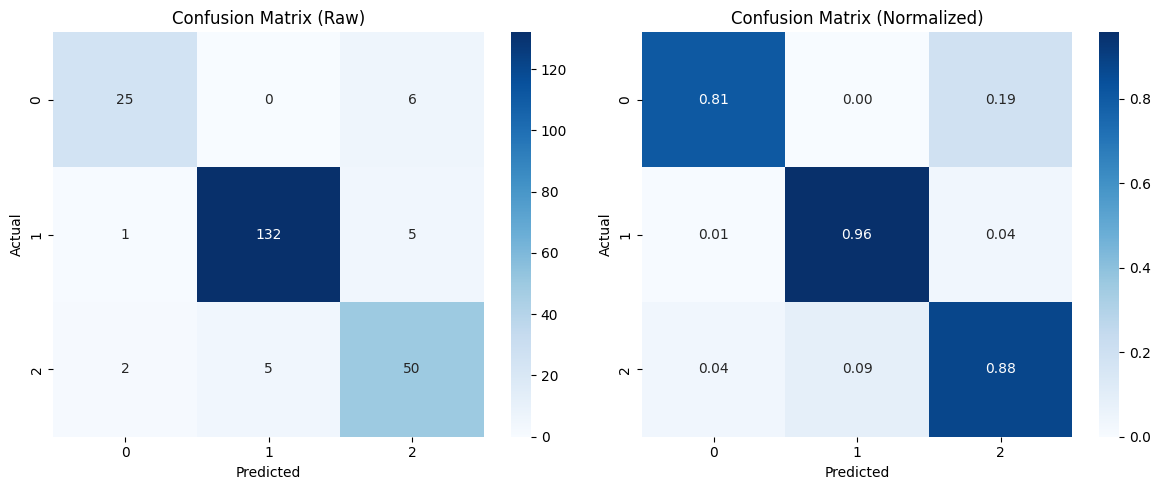


Best model accuracy: 0.915929
Best model precision: 0.917537
Best model recall: 0.915929
Best model f1 score: 0.884972


In [14]:
cm = confusion_matrix(test_labels, test_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            ax=axes[0])

axes[0].set_title("Confusion Matrix (Raw)")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")


sns.heatmap(cm_normalized,
            annot=True,
            fmt='.2f',
            cmap='Blues',
            ax=axes[1])

axes[1].set_title("Confusion Matrix (Normalized)")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()

acc = accuracy_score(test_labels, test_preds)

precision_weighted = precision_score(test_labels, test_preds, average='weighted')
recall_weighted = recall_score(test_labels, test_preds, average='weighted')
f1_macro = f1_score(test_labels, test_preds, average='macro')

print()
print(f"Best model accuracy: {acc:.6f}")
print(f"Best model precision: {precision_weighted:.6f}")
print(f"Best model recall: {recall_weighted:.6f}")
print(f"Best model f1 score: {f1_macro:.6f}")


  <h1 style="color:#0F5298; font-family:serif; font-size:45px; margin-bottom:0px;">
    Test, Export CSV of Result
  </h1>

In [15]:
# --- Export CSV of Result (input: row_id,sentence | output: row_id,predict) ---
input_csv_path = "sentences.csv"   # must contain: row_id, sentence
output_csv_path = "output.csv"

if not os.path.exists(input_csv_path):
    raise FileNotFoundError(f"Input CSV not found: {input_csv_path}")

input_df = pd.read_csv(input_csv_path)
required_cols = {"row_id", "sentence"}
missing = required_cols - set(input_df.columns)
if missing:
    raise ValueError(f"Missing required columns in input CSV: {sorted(missing)}")

input_df = input_df.dropna(subset=["row_id", "sentence"]).copy()
input_df["sentence"] = input_df["sentence"].astype(str).str.strip()
input_df = input_df[input_df["sentence"] != ""].reset_index(drop=True)

if len(input_df) == 0:
    raise ValueError("No valid rows found after cleaning input CSV.")

if "device" not in globals():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if "tokenizer" not in globals() or tokenizer is None:
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

if "model" not in globals() or model is None:
    if not os.path.exists("best-model.pt"):
        raise RuntimeError("No active model found and best-model.pt is missing.")
    if "build_model_from_config" not in globals():
        raise RuntimeError("build_model_from_config is not defined. Run model-definition cells first.")

    checkpoint = torch.load("best-model.pt", map_location=device, weights_only=False)
    ckpt_config = checkpoint["config"]
    pretrained_for_infer = pretrained_embeddings if "pretrained_embeddings" in globals() else None

    model = build_model_from_config(
        config=ckpt_config,
        pretrained_embeddings=pretrained_for_infer,
        device=device,
    )
    model.load_state_dict(checkpoint["model_state_dict"])

model = model.to(device)
model.eval()

max_len_infer = MAX_LEN if "MAX_LEN" in globals() else getattr(model.position_embedding, "num_embeddings", 64)
batch_size_infer = BATCH_SIZE if "BATCH_SIZE" in globals() else 32

texts = input_df["sentence"].tolist()
pred_ids = []

with torch.no_grad():
    for i in range(0, len(texts), batch_size_infer):
        batch_texts = texts[i:i + batch_size_infer]
        enc = tokenizer(
            batch_texts,
            add_special_tokens=True,
            max_length=max_len_infer,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt",
        )

        input_ids = enc["input_ids"].to(device)
        attention_mask = enc["attention_mask"].to(device)
        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(logits, dim=1)
        pred_ids.extend(preds.detach().cpu().numpy().tolist())

id2label = {0: "Negative", 1: "Neutral", 2: "Positive"}
if "label_names" in globals() and isinstance(label_names, dict):
    id2label = {int(k): str(v) for k, v in label_names.items()}

predicted_labels = [id2label.get(i, "Unknown") for i in pred_ids]

out_df = pd.DataFrame({
    "row_id": input_df["row_id"].values,
    "label": predicted_labels,
})
out_df.to_csv(output_csv_path, index=False)
print(f"Saved {len(out_df)} rows to: {output_csv_path}")
display(out_df.head(10))

Saved 300 rows to: output.csv


,row_id,label
0,0,Positive
1,1,Neutral
2,2,Negative
3,3,Neutral
4,4,Negative
5,5,Neutral
6,6,Neutral
7,7,Negative
8,8,Negative
9,9,Positive


  <h1 style="color:#0F5298; font-family:serif; font-size:45px; margin-bottom:0px;">
    Last-layer attention heatmaps
  </h1>

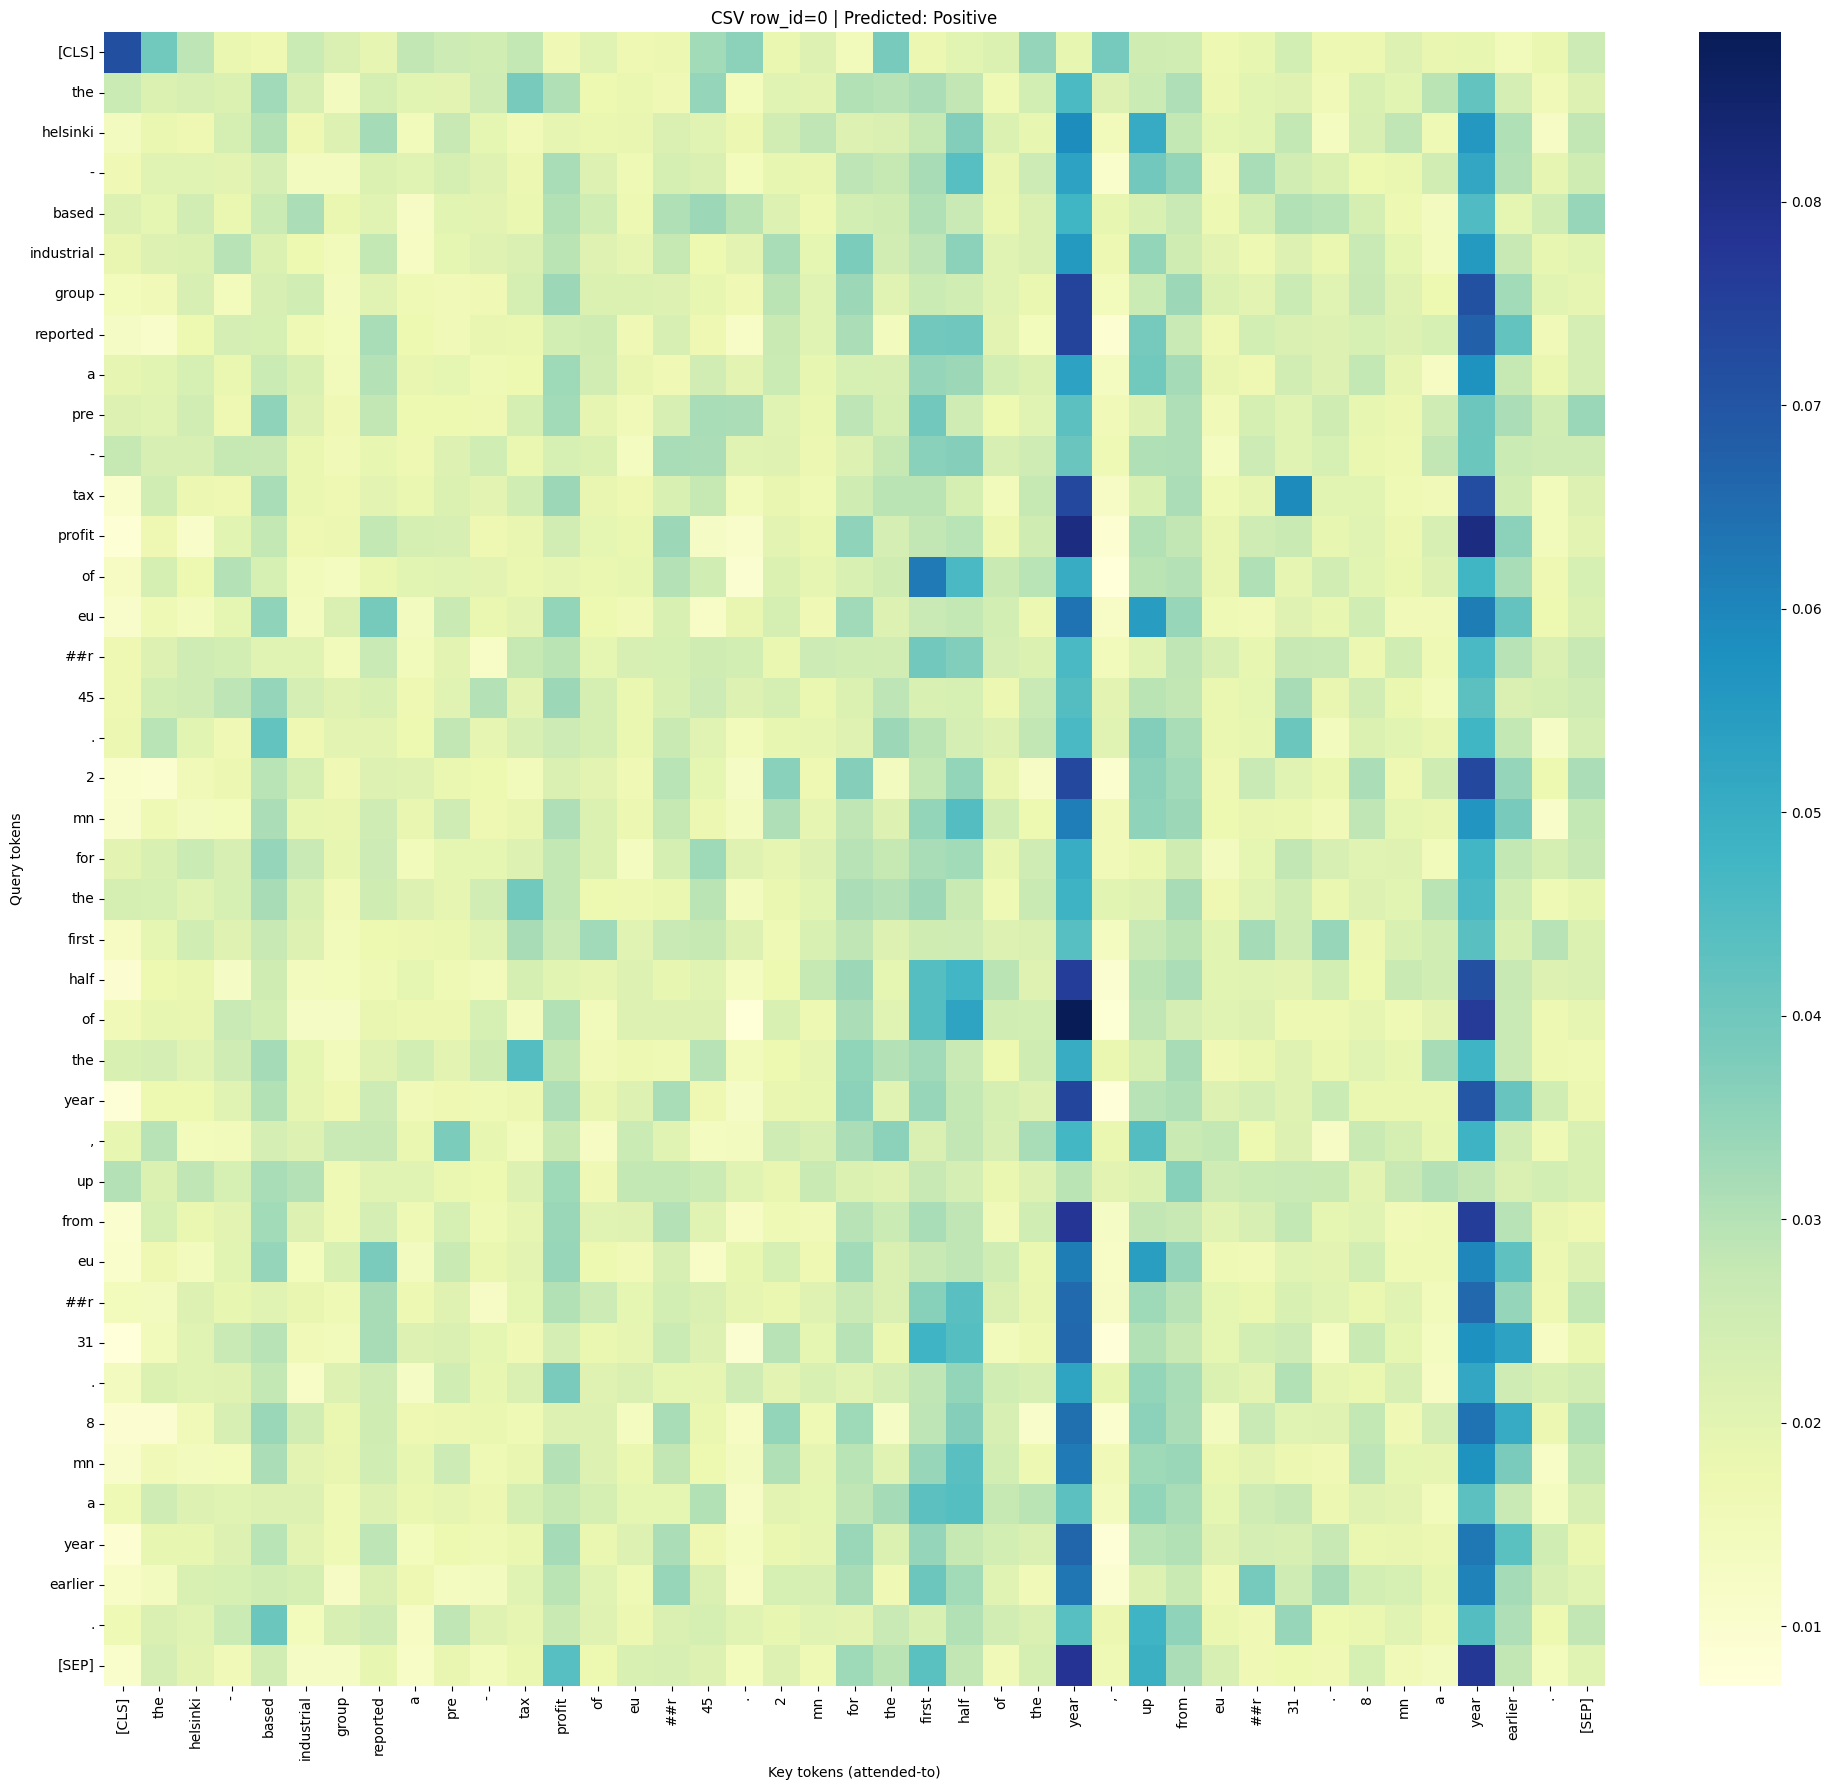

Sentence 1 from CSV (row_id=0): The Helsinki-based industrial group reported a pre-tax profit of EUR 45.2 mn for the first half of the year , up from EUR 31.8 mn a year earlier .
Top attended tokens (last layer): ['year', 'year', 'first', 'half', 'up']
--------------------------------------------------------------------------------


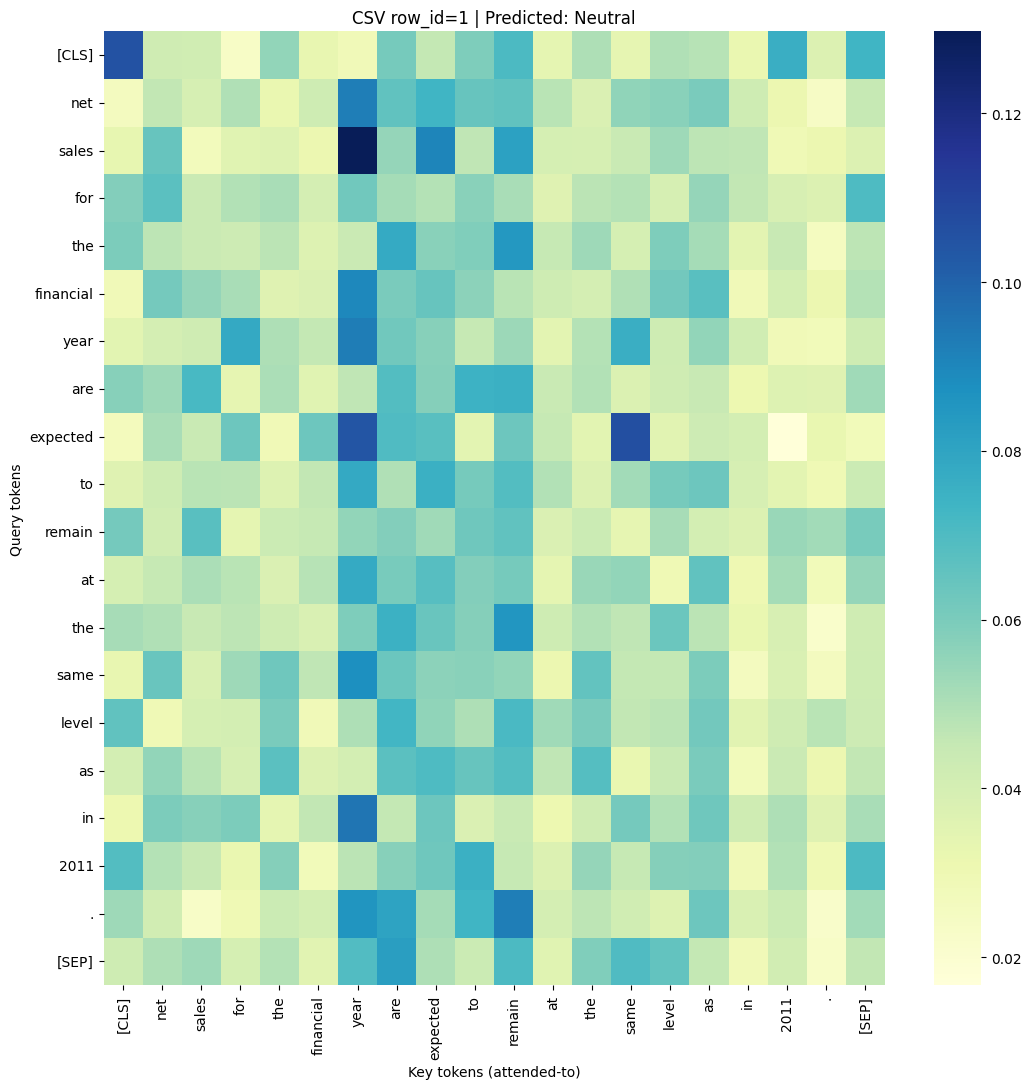

Sentence 2 from CSV (row_id=1): Net sales for the financial year are expected to remain at the same level as in 2011 .
Top attended tokens (last layer): ['year', 'remain', 'are', 'expected', 'to']
--------------------------------------------------------------------------------


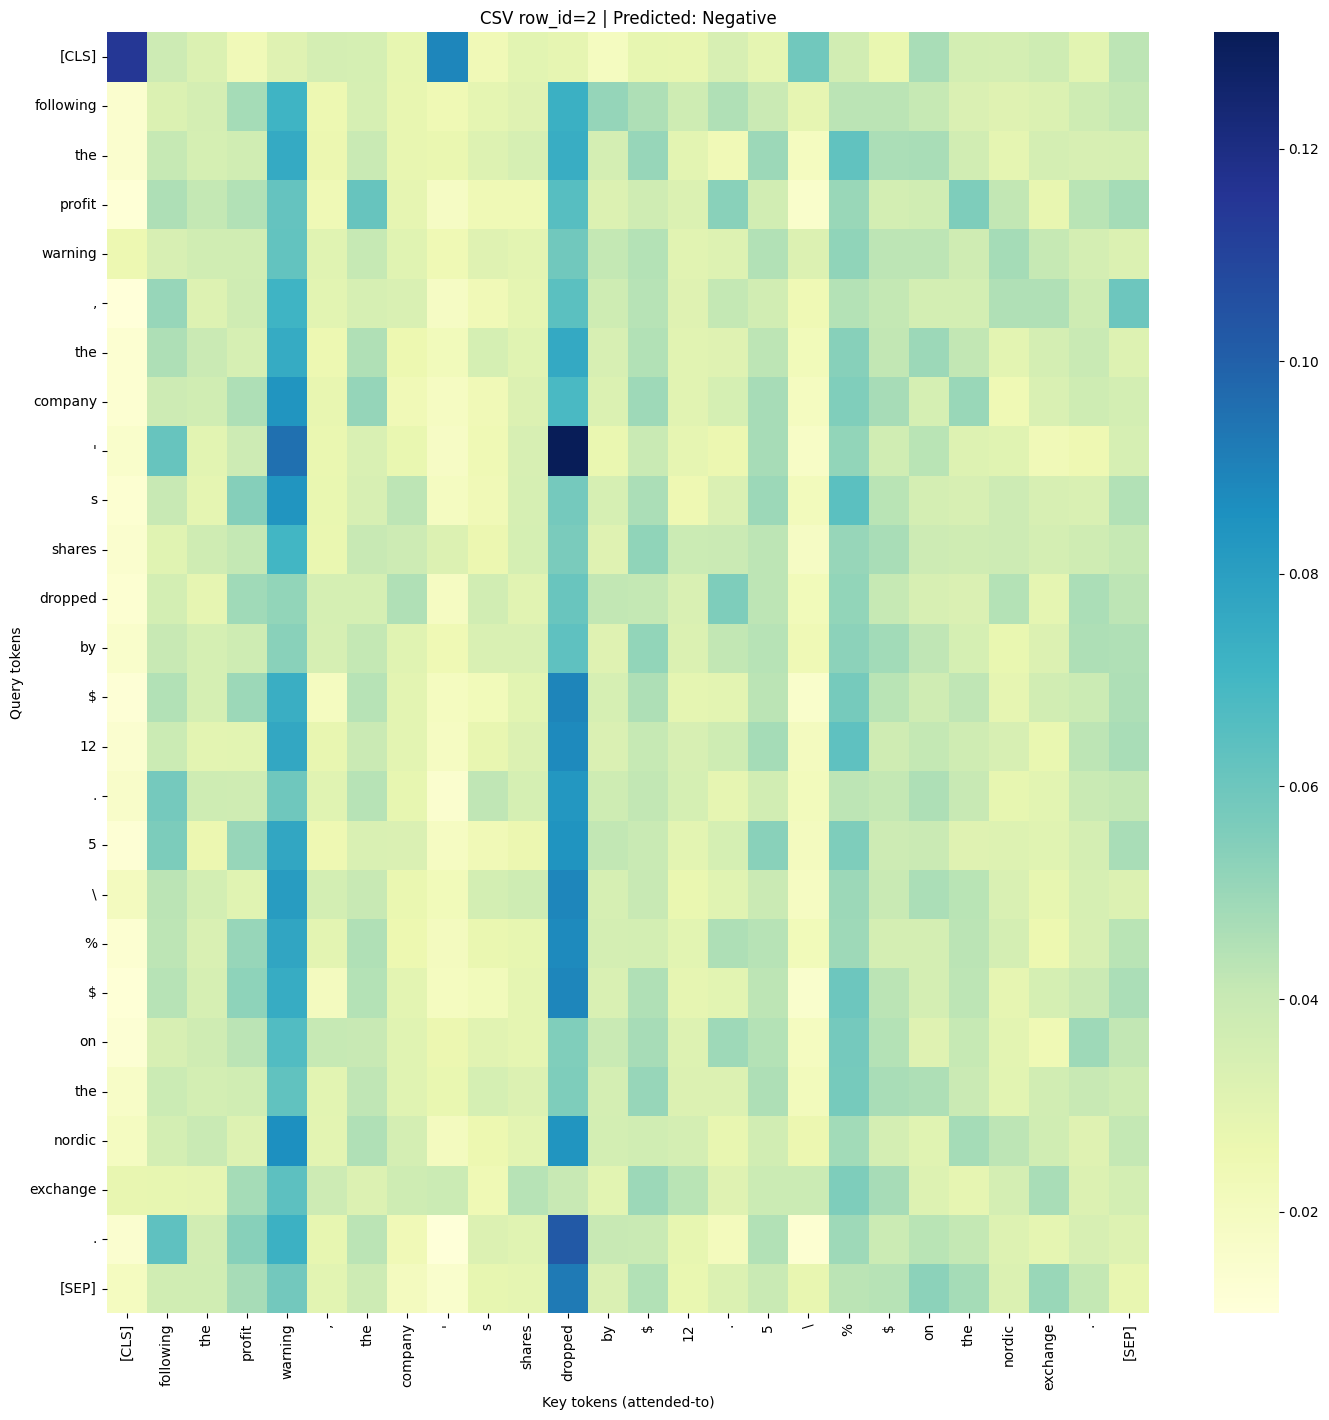

Sentence 3 from CSV (row_id=2): Following the profit warning , the company 's shares dropped by $12.5\%$ on the Nordic Exchange .
Top attended tokens (last layer): ['dropped', 'warning', '%', '$', '5']
--------------------------------------------------------------------------------


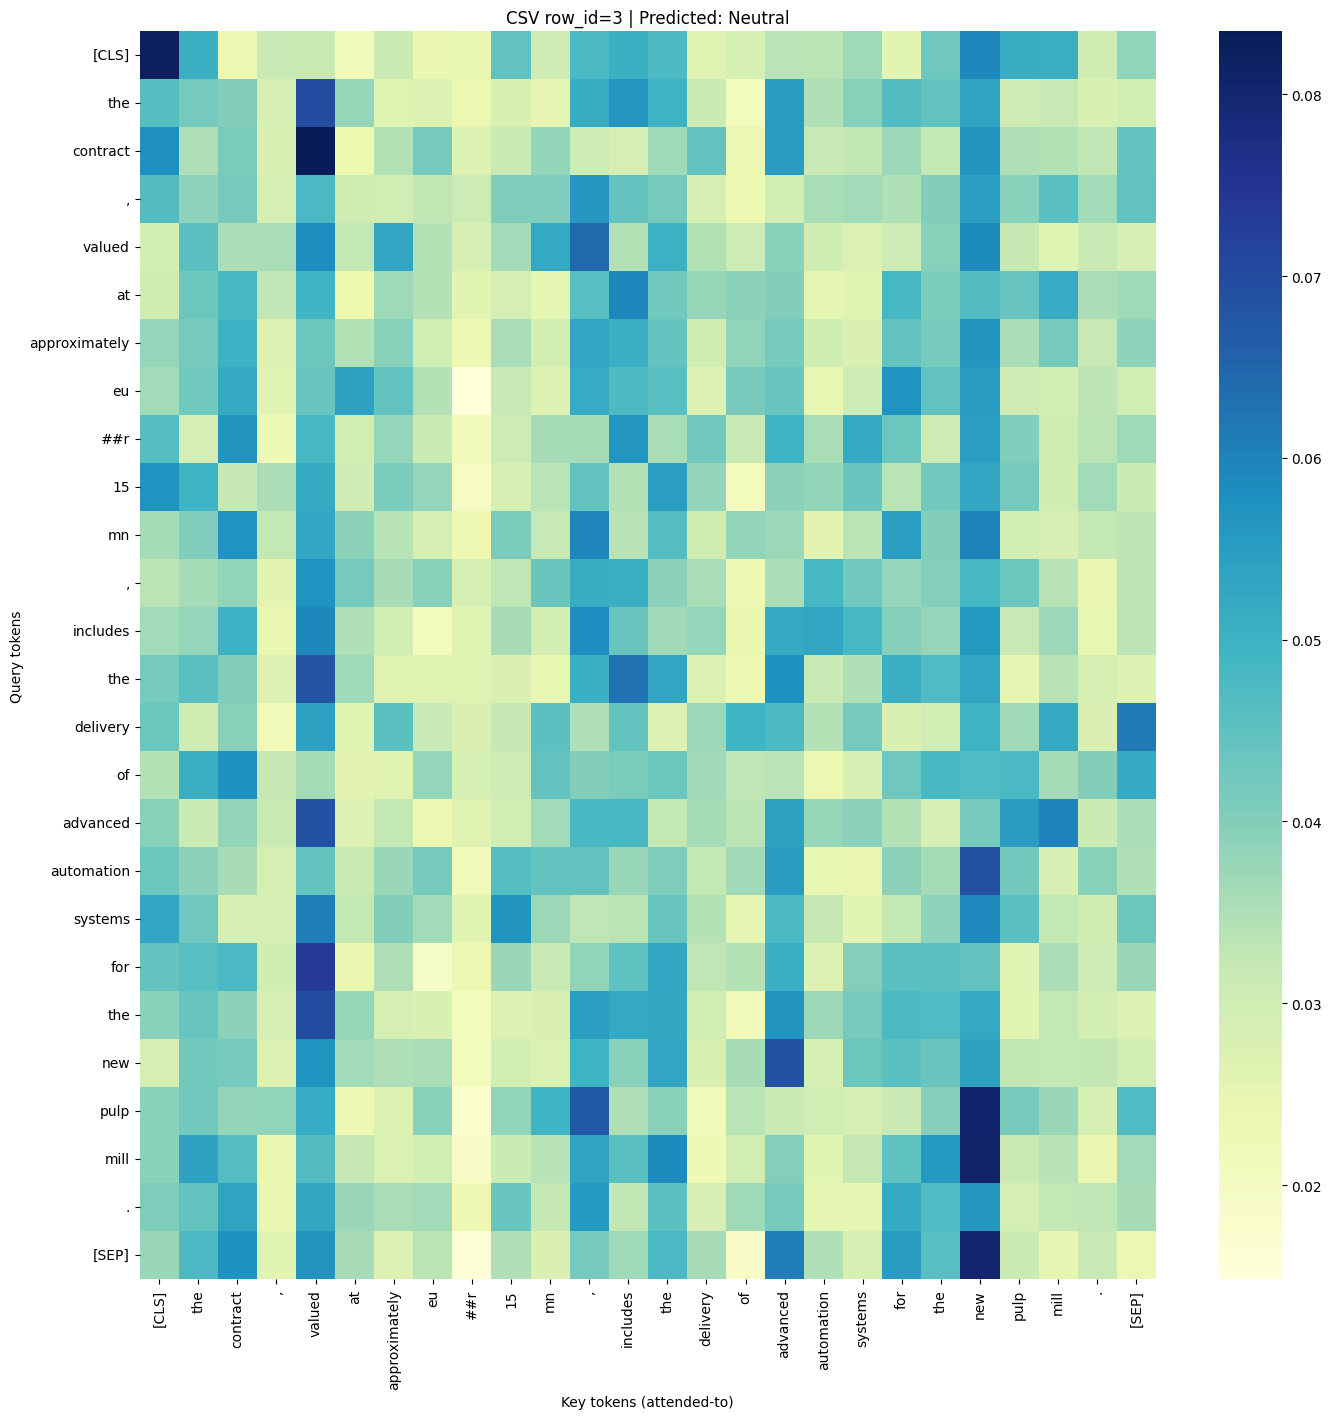

Sentence 4 from CSV (row_id=3): The contract , valued at approximately EUR 15 mn , includes the delivery of advanced automation systems for the new pulp mill .
Top attended tokens (last layer): ['new', 'valued', ',', 'advanced', 'the']
--------------------------------------------------------------------------------


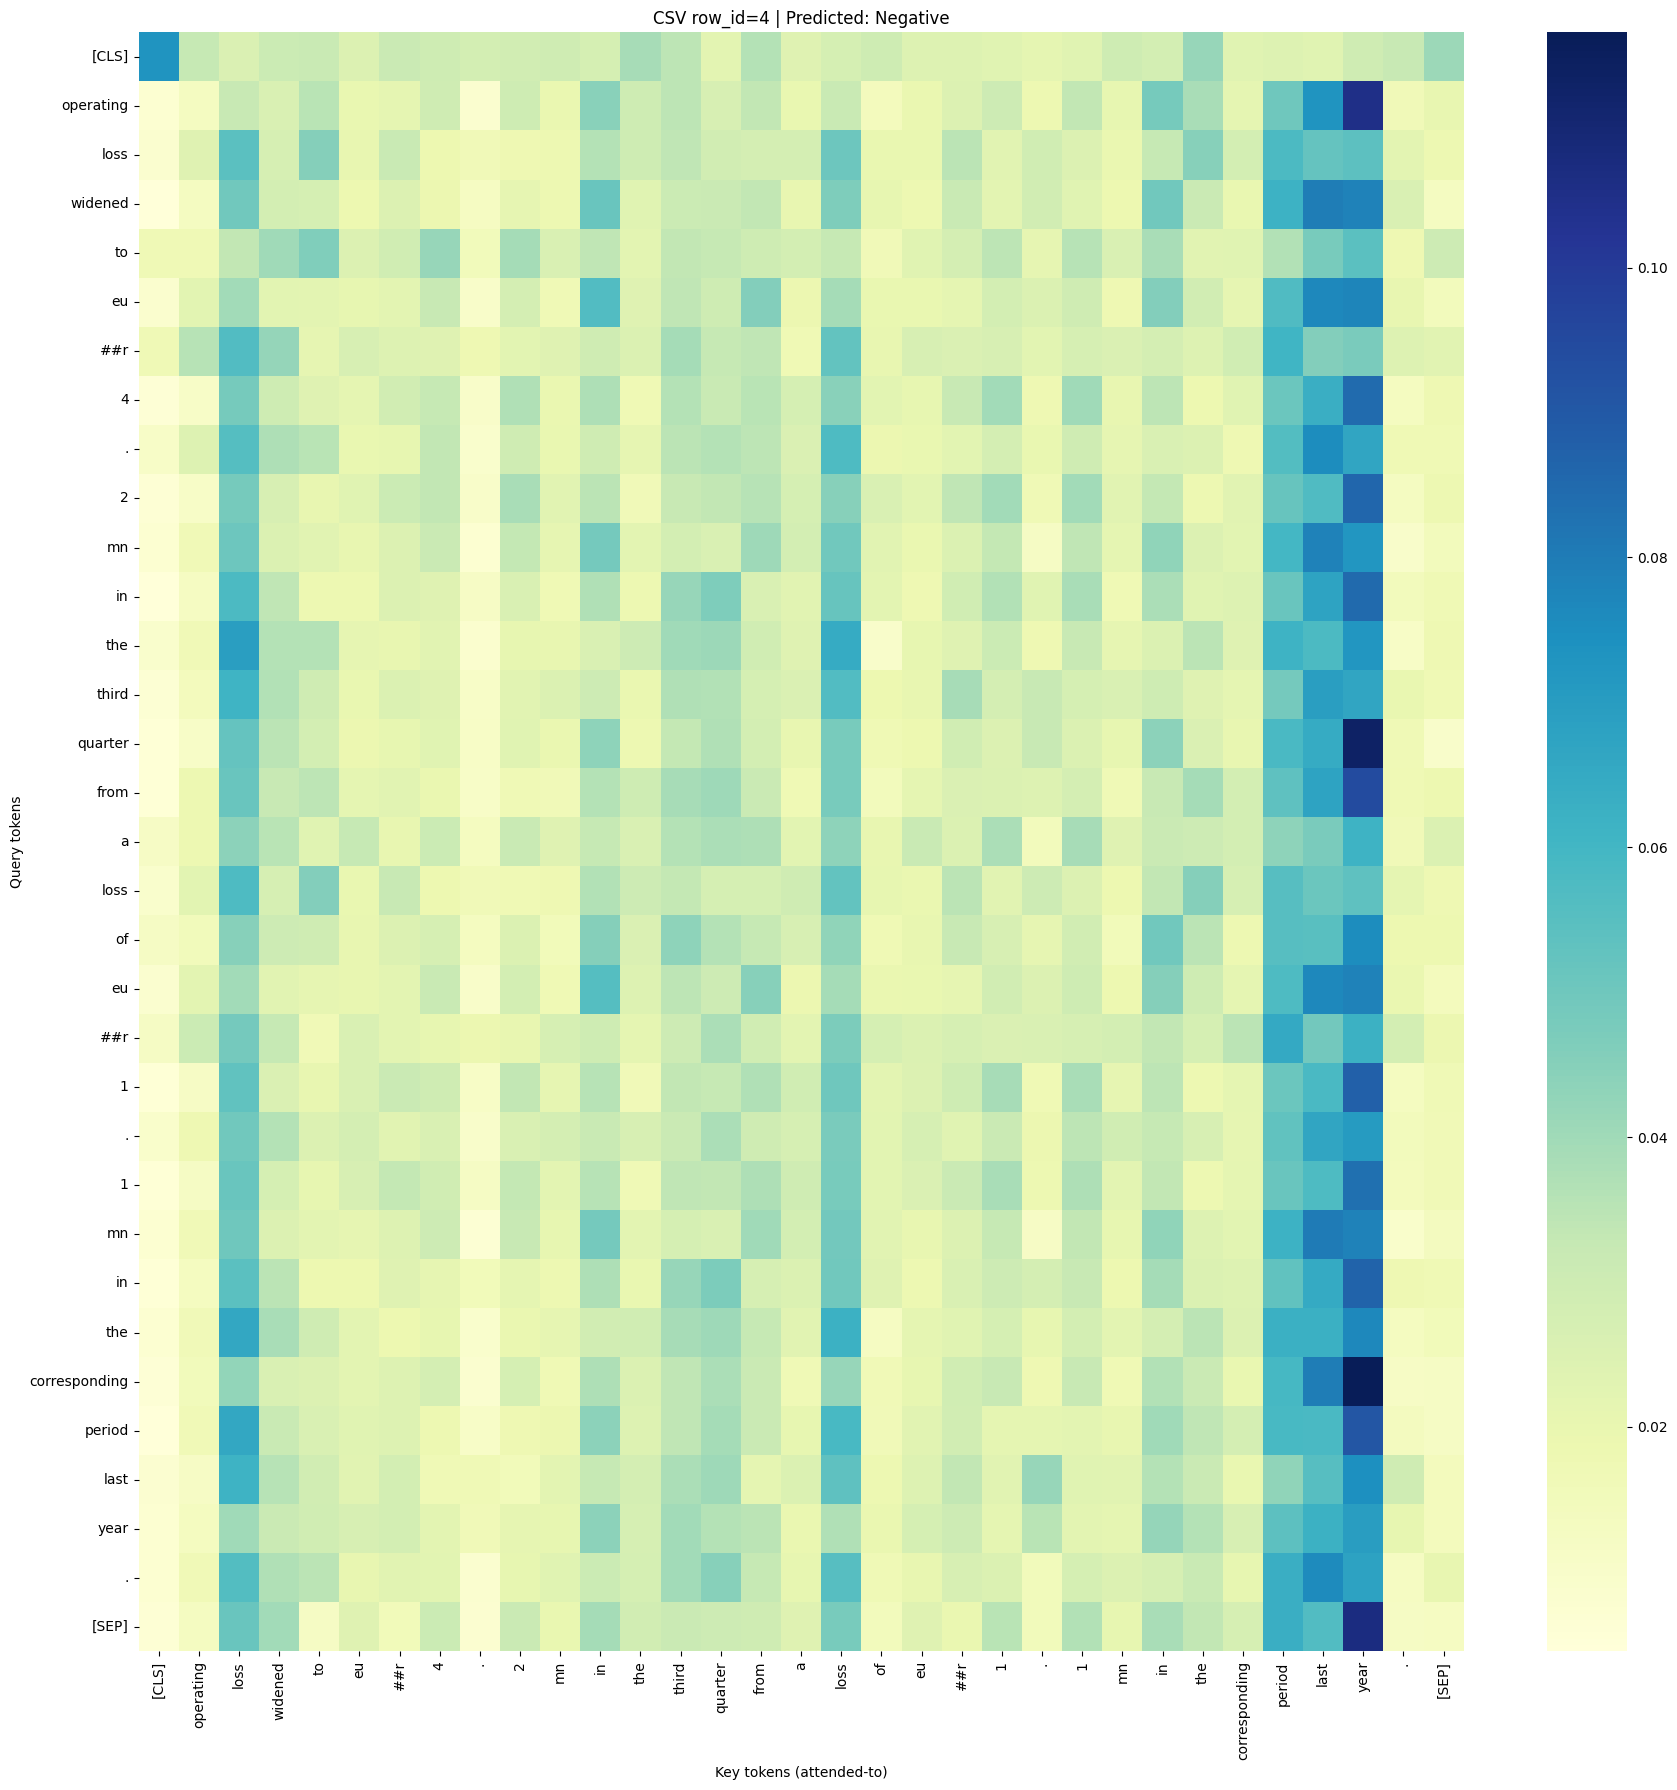

Sentence 5 from CSV (row_id=4): Operating loss widened to EUR 4.2 mn in the third quarter from a loss of EUR 1.1 mn in the corresponding period last year .
Top attended tokens (last layer): ['year', 'last', 'period', 'loss', 'loss']
--------------------------------------------------------------------------------


In [16]:
# --- Last-layer attention heatmaps for first 5 REAL test CSV sentences ---
csv_for_attn = input_csv_path if "input_csv_path" in globals() else "test.csv"

if not os.path.exists(csv_for_attn):
    raise FileNotFoundError(f"Input CSV not found for attention heatmap: {csv_for_attn}")

attn_df = pd.read_csv(csv_for_attn)
required_cols = {"row_id", "sentence"}
missing = required_cols - set(attn_df.columns)
if missing:
    raise ValueError(f"Missing required columns in attention CSV: {sorted(missing)}")

attn_df = attn_df.dropna(subset=["row_id", "sentence"]).copy()
attn_df["sentence"] = attn_df["sentence"].astype(str).str.strip()
attn_df = attn_df[attn_df["sentence"] != ""].reset_index(drop=True)

if len(attn_df) == 0:
    raise ValueError("No valid rows found in attention CSV after cleaning.")

sample_df = attn_df.head(5).reset_index(drop=True)

if "device" not in globals():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if "tokenizer" not in globals() or tokenizer is None:
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

if "model" not in globals() or model is None:
    if not os.path.exists("best-model.pt"):
        raise RuntimeError("No active model found and best-model.pt is missing.")
    if "build_model_from_config" not in globals():
        raise RuntimeError("build_model_from_config is not defined. Run model-definition cells first.")

    checkpoint = torch.load("best-model.pt", map_location=device, weights_only=False)
    ckpt_config = checkpoint["config"]
    pretrained_for_infer = pretrained_embeddings if "pretrained_embeddings" in globals() else None

    model = build_model_from_config(
        config=ckpt_config,
        pretrained_embeddings=pretrained_for_infer,
        device=device,
    )
    model.load_state_dict(checkpoint["model_state_dict"])

id2label = {0: "Negative", 1: "Neutral", 2: "Positive"}
if "label_names" in globals() and isinstance(label_names, dict):
    id2label = {int(k): str(v) for k, v in label_names.items()}

model = model.to(device)
model.eval()
max_len_infer = MAX_LEN if "MAX_LEN" in globals() else getattr(model.position_embedding, "num_embeddings", 64)

for i, row in sample_df.iterrows():
    row_id = row["row_id"]
    text = str(row["sentence"])

    enc = tokenizer(
        text,
        add_special_tokens=True,
        max_length=max_len_infer,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        return_tensors="pt",
    )

    input_ids = enc["input_ids"].to(device)
    attention_mask = enc["attention_mask"].to(device)

    with torch.no_grad():
        logits, attn_maps = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_attention=True,
        )

    pred_id = int(torch.argmax(logits, dim=1).item())
    pred_label = id2label.get(pred_id, str(pred_id))

    last_layer_attn = attn_maps[-1][0]  # [num_heads, seq_len, seq_len]
    attn_avg = last_layer_attn.mean(dim=0).detach().cpu().numpy()

    valid_len = int(attention_mask[0].sum().item())
    attn_avg = attn_avg[:valid_len, :valid_len]

    token_ids = input_ids[0][:valid_len].detach().cpu().tolist()
    tokens = tokenizer.convert_ids_to_tokens(token_ids)

    token_importance = attn_avg.mean(axis=0)
    top_k = min(5, len(tokens))
    top_idx = np.argsort(-token_importance)[:top_k]
    top_tokens = [tokens[j] for j in top_idx]

    fig_w = min(20, max(8, 0.55 * len(tokens)))
    fig_h = min(18, max(6, 0.55 * len(tokens)))
    plt.figure(figsize=(fig_w, fig_h))
    sns.heatmap(
        attn_avg,
        xticklabels=tokens,
        yticklabels=tokens,
        cmap="YlGnBu",
        cbar=True,
    )
    plt.title(f"CSV row_id={row_id} | Predicted: {pred_label}")
    plt.xlabel("Key tokens (attended-to)")
    plt.ylabel("Query tokens")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    print(f"Sentence {i+1} from CSV (row_id={row_id}): {text}")
    print(f"Top attended tokens (last layer): {top_tokens}")
    print("-" * 80)
